In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import rustworkx as rw
from tqdm import tqdm

from ev_station_solver.constants import CONSTANTS
from ev_station_solver.helper_functions import get_distance_matrix
from ev_station_solver.loading import load_locations
from ev_station_solver.solving.solver import Solver
from ev_station_solver.logging import get_logger

logger = get_logger(__name__, logging.DEBUG)

# Try to find initial locations, deterministically...

In [2]:
# use given starting solutions
locations = load_locations("medium").sample(1000).values
n_clusters = int(len(locations) * CONSTANTS["mu_charging"] / (2 * CONSTANTS["station_ub"]))
service_level = 0.95

n_clusters = 3 if n_clusters < 3 else n_clusters

In [3]:
# current approach with k means
s = Solver(vehicle_locations=locations, loglevel=logging.INFO, service_level=service_level)

# compute number of initial locations
s.add_initial_locations(n_clusters, mode="k-means", seed=0)
s.add_samples(num=2)

2025-01-13 16:09:34,599 - ev_station_solver.solving.solver - INFO - add_initial_locations: Added 26 k-means locations. Total number of locations: 26.
2025-01-13 16:09:34,602 - ev_station_solver.solving.solver - INFO - add_samples: Added 2 samples.


2025-01-13 16:09:34,614 - matplotlib.pyplot - DEBUG - switch_backend: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-01-13 16:09:34,617 - matplotlib.pyplot - DEBUG - switch_backend: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-01-13 16:09:34,624 - matplotlib.font_manager - DEBUG - _findfont_cached: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2025-01-13 16:09:34,632 - matplotlib.font_manager - DEBUG - _findfont_cached: findfont: score(FontEntry(fname='/Users/justuswolff_private/Repositories/ev-station-solver/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2025-01-13 16:09:34,635 - matplotlib.font_manager - DEBUG - _findfont_cached: findfont: score(FontEntry(fname='/Users/justuswolff_private/Repositories/ev-station-solver/.venv/lib/pyth

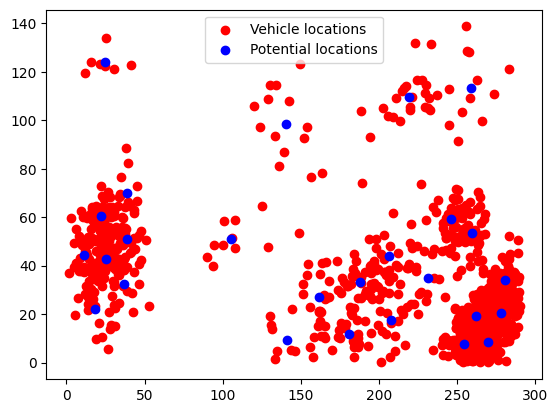

In [4]:
plt.scatter(s.vehicle_locations[:, 0], s.vehicle_locations[:, 1], c="red", label="Vehicle locations")
plt.scatter(s.coordinates_potential_cl[:, 0], s.coordinates_potential_cl[:, 1], c="blue", label="Potential locations")
plt.legend()
plt.show()

In [5]:
# Updated approach

In [6]:
# create dataframe with all unique locations and the minimum range
locations = np.empty((0, 2))
ranges = np.empty(0)

for sample in s.S:
    # concatenate locations
    locations = np.concatenate((locations, sample.vehicle_locations), axis=0)
    # concatenate ranges
    ranges = np.concatenate((ranges, sample.ranges), axis=0)

In [7]:
# sort locations by range
sorted_indices = np.argsort(ranges)
locations = locations[sorted_indices]
ranges = ranges[sorted_indices]

In [8]:
# drop duplicates
unique_locations, unique_index = np.unique(locations, axis=0, return_index=True)
# update ranges
unique_ranges = ranges[unique_index]

In [9]:
# get distance matrix
distance_matrix = get_distance_matrix(unique_locations, symmetric=True)
total_ranges = unique_ranges[:, np.newaxis] + unique_ranges[np.newaxis, :]
reachibility_matrix = distance_matrix <= total_ranges
reachibility_matrix

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]], shape=(695, 695))

In [10]:
# create graph from adjacency matrix
G = rw.PyGraph().from_adjacency_matrix(reachibility_matrix.astype(float))  # create graph from adjacency matrix

## New Idea
1. Compute graph
2. compute degress
3. select largest degrees with the smallest range and its neighbours with edges in that subgraph
4. compute maximum clique
5. add ceil nq charing locattions at geometric median with range constraints
6. delete all vertices in maximum clique from main graph
7. repeat from 2

In [11]:
def apply_algorithm_step(graph: rw.PyGraph):
    degrees = [(node, G.degree(node)) for node in G.node_indices()]  # get degrees of all nodes
    max_degree_node = max(degrees, key=lambda x: x[1])  # get node with maximum degree

    # get all neighbors of the node with maximum degree
    neighbors = G.neighbors(max_degree_node[0])
    # create a subgrpah with all neighbors and edges between them
    subgraph = G.subgraph(neighbors + [max_degree_node[0]])

    # get the connected components of the subgraph
    connected_components = subgraph.connected_components()

    return max_degree_node

In [12]:
degrees = [(node, G.degree(node)) for node in G.node_indices()]  # get degrees of all nodes
max_degree_node = max(degrees, key=lambda x: x[1])  # get node with maximum degree
max_degree_node

(169, 696)

In [13]:
# get all neighbors of the node with maximum degree
neighbors = G.neighbors(max_degree_node[0])
# create a subgrpah with all neighbors and edges between them
subgraph = G.subgraph(list(neighbors) + [max_degree_node[0]])

In [14]:
def get_max_connected_subgraph(g: rw.PyGraph):
    max_k = len(g.node_indices())

    for k in range(max_k, 0, -1):
        logger.debug(f"Trying to find connected subgraph with {k} nodes")
        connected_subgraphs = rw.connected_subgraphs(g, k)
        if len(connected_subgraphs) > 0:
            return connected_subgraphs[0]

    raise ValueError("No connected subgraph found")

In [ ]:
# get_max_connected_subgraph(subgraph)

In [45]:
r = rw.connected_subgraphs(subgraph, 1)

TypeError: connected_subgraphs() missing 1 required positional argument: 'k'

In [44]:
len(r[0])

657

In [40]:
len(subgraph.node_indices())

657

In [30]:
apply_algorithm_step(G)

(208, 658)

In [26]:
[(node, G.degree(node)) for node in G.node_indices()]

[(0, 231),
 (1, 178),
 (2, 178),
 (3, 248),
 (4, 174),
 (5, 158),
 (6, 161),
 (7, 170),
 (8, 158),
 (9, 177),
 (10, 276),
 (11, 168),
 (12, 178),
 (13, 179),
 (14, 166),
 (15, 197),
 (16, 181),
 (17, 174),
 (18, 172),
 (19, 182),
 (20, 160),
 (21, 171),
 (22, 188),
 (23, 190),
 (24, 186),
 (25, 177),
 (26, 172),
 (27, 164),
 (28, 191),
 (29, 243),
 (30, 192),
 (31, 169),
 (32, 179),
 (33, 174),
 (34, 223),
 (35, 236),
 (36, 175),
 (37, 195),
 (38, 191),
 (39, 177),
 (40, 173),
 (41, 181),
 (42, 256),
 (43, 196),
 (44, 194),
 (45, 224),
 (46, 246),
 (47, 213),
 (48, 259),
 (49, 217),
 (50, 167),
 (51, 178),
 (52, 166),
 (53, 192),
 (54, 164),
 (55, 245),
 (56, 170),
 (57, 207),
 (58, 195),
 (59, 176),
 (60, 191),
 (61, 196),
 (62, 174),
 (63, 200),
 (64, 250),
 (65, 160),
 (66, 289),
 (67, 207),
 (68, 175),
 (69, 169),
 (70, 174),
 (71, 173),
 (72, 146),
 (73, 180),
 (74, 176),
 (75, 212),
 (76, 243),
 (77, 260),
 (78, 192),
 (79, 192),
 (80, 237),
 (81, 206),
 (82, 163),
 (83, 175),
 (

In [41]:
results = []
for i, k in enumerate(tqdm(range(len(unique_locations))[::-1])):
    results.append(rw.connected_subgraphs(G, k=k))

    if i == 1:
        break

: 

: 

In [16]:
k

26

In [15]:
results

[[[5,
   14,
   15,
   2,
   13,
   6,
   22,
   27,
   20,
   7,
   25,
   17,
   11,
   3,
   28,
   12,
   1,
   18,
   4,
   8,
   0,
   21,
   23,
   10,
   16,
   26,
   19,
   24],
  [5,
   14,
   15,
   2,
   13,
   6,
   22,
   27,
   20,
   25,
   17,
   11,
   3,
   28,
   12,
   1,
   9,
   18,
   4,
   8,
   0,
   21,
   23,
   10,
   16,
   26,
   19,
   24],
  [7,
   14,
   15,
   2,
   13,
   6,
   22,
   27,
   20,
   25,
   17,
   11,
   3,
   28,
   12,
   1,
   9,
   18,
   4,
   8,
   0,
   21,
   23,
   10,
   16,
   26,
   19,
   24],
  [7,
   14,
   15,
   2,
   13,
   6,
   22,
   27,
   20,
   25,
   17,
   11,
   3,
   28,
   12,
   1,
   9,
   18,
   4,
   8,
   0,
   21,
   23,
   10,
   16,
   26,
   19,
   5],
  [7,
   14,
   15,
   2,
   13,
   6,
   22,
   27,
   20,
   25,
   17,
   11,
   3,
   28,
   12,
   1,
   9,
   18,
   4,
   8,
   0,
   21,
   23,
   10,
   24,
   26,
   19,
   5],
  [7,
   14,
   15,
   2,
   13,
   6,
   22,
   27,
   20,
  

In [14]:
for k in tqdm(range(len(unique_locations))):
    rw.connected_subgraphs(G, k=k)

 14%|█▍        | 5/35 [00:24<00:00, 35.34it/s]Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1046d2e60>>
Traceback (most recent call last):
  File "/Users/justuswolff_private/Repositories/ev-station-solver/.venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


: 

: 

In [13]:
unique_locations

array([[  4.93,  39.61],
       [ 13.33,  44.23],
       [ 16.34,  63.31],
       [ 26.72,   5.68],
       [ 27.24,  54.37],
       [ 29.65,  33.47],
       [ 45.14,  66.55],
       [106.17,  51.6 ],
       [125.22,  64.62],
       [134.97,   4.67],
       [173.74,  10.72],
       [199.85,  26.26],
       [202.02,  13.11],
       [203.09,  42.6 ],
       [208.82,  36.83],
       [218.19,  39.01],
       [219.83, 104.17],
       [248.48,  60.21],
       [250.99,  62.22],
       [251.09,   8.78],
       [252.23,  11.12],
       [255.89,  64.94],
       [258.31,  43.73],
       [263.99,  10.3 ],
       [264.82,   4.85],
       [266.15,  25.19],
       [267.98,  14.93],
       [270.53,  19.95],
       [270.66,  27.32],
       [271.28,  22.57],
       [273.29,  27.93],
       [273.32, 110.71],
       [281.97,  24.86],
       [283.63,  23.29],
       [284.62,  20.71]])